In [1]:
import copy
import xarray as xr
import gsw
import pandas as pd
from xmitgcm import open_mdsdataset
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams.update({'font.size': 14
    , 'legend.markerscale': 1., 'axes.titlesize': 16, 'axes.labelsize' : 14,
      'legend.fontsize' : 10,'legend.handlelength': 2})

plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

In [25]:
data_dir = '/swot/SUM01/tongya/cox/fine/run_quik_ex2/'

ds = open_mdsdataset(data_dir,prefix={'etan_ave','xyMom_ave','theta_ave'}).chunk()

lon = ds.XC
lat = ds.YC
lev = ds.Z

uu = ds['UVEL'][50:100, :, :, :]
uu = uu.mean(dim='time')
uu = uu.where(uu != 0)

uz = np.zeros((600, 1440))
dzz  = np.zeros((29,  600, 1440))
dztmp  = np.zeros((29,  600))

for j in np.arange(600):
    dztmp[:, j] = ds.drF.values
for i in np.arange(1440):
    dzz[:, :, i] = dztmp
    
#for i in np.arange(1440):
#    for j in np.arange(80, 400, 1):
#        uz[j, i] = np.sum(uu[:20, j, i].values * ds.drF.values[:20]) / np.sum(ds.drF.values[:20])


/home/tls2913/.conda/envs/geo_scipy/lib/python3.6/site-packages/xmitgcm/utils.py:336: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)


## Rossby radius

In [20]:
data_dir = '/swot/SUM01/tongya/cox/fine/run_quik_ex2/'

ds = open_mdsdataset(data_dir,prefix={'etan_ave','xyMom_ave','theta_ave'}).chunk()

lon = ds.XC
lat = ds.YC
lev = ds.Z

temp = ds['THETA'][50:100, :, :, :]
temp = temp.mean(dim='time')
temp = temp.where(temp > 0).values

salt = copy.deepcopy(temp)
salt[:, :, :] = 35

mask = ds.hFacC[-2, :, :].values
basin = (np.sum(mask,1)/10)

/home/tls2913/.conda/envs/geo_scipy/lib/python3.6/site-packages/xmitgcm/utils.py:336: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)


In [21]:
c1 = np.zeros((600, 1440))
rad = np.zeros((600, 1440))
ps =  np.zeros((600, 1440))
c1[:, :] = np.nan
rad[:, :] = np.nan
ps[:, :] = np.nan

for i in np.arange(1440):
    for j in np.arange(80, 400, 1):
        
        tt0 = temp[:, j, i]
        ss0 = salt[:, j, i]

        [N2, p_mid] = gsw.Nsquared(ss0, tt0, -lev, lat[j])

        N_int = np.nansum(np.sqrt(N2) * np.diff(ds.drF.values, 0)[:28])

        c1[j, i] = N_int / np.pi

        rad[j, i] = c1[j, i] / gsw.f(lat[j])
        #num = basin[j]
        ps[j, i] = (gsw.f(lat[j+1]) - gsw.f(lat[j]))/10000 / ((1/rad[j, i])**2) # + (1/(num*1000))**2) 08.16

/home/tls2913/.conda/envs/geo_scipy/lib/python3.6/site-packages/ipykernel/__main__.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/home/tls2913/.conda/envs/geo_scipy/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in sqrt


In [26]:
uz = np.sum(uu * dzz, 0)  / np.sum(ds.drF.values)
uc = uz - ps

## Rad

(25,)

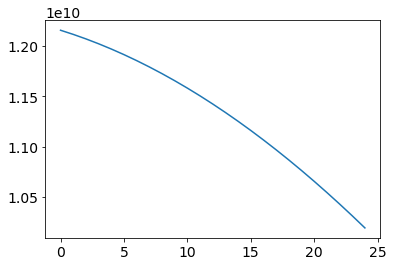

In [3]:
lt = np.zeros((26, 2))
lt[:, 0] = np.arange(10.5, 36, 1)
lt[:, 1] = np.arange(10.5, 36, 1)

ln = np.zeros((26, 2))
for i in np.arange(26):
    ln[i, 0] = 0
    ln[i, 1] = 1
l1 = gsw.distance(ln, lt, axis=1)
l2 = gsw.distance(ln, lt, axis=0)
area = l1[:25] * l2[:, 0].T
area = area[:,0]
plt.plot(area);
area.shape

In [4]:
def compute_radius(lat, num):
    lat0 = np.arange(10.5, 35.5, 1)
    
    index = np.abs(lat0 - lat).argmin()
    radius = np.sqrt((area[index] /6400 /1e6 * num)/ np.pi)
    
    return radius

In [5]:
def find_nearest_id(x0, x1):
    index = np.abs(x0 - x1).argmin()
    return index

In [6]:
rclv_x0 = np.arange(1/160, 144, 1/80)
rclv_y0 = np.arange(1/160, 25, 1/80) + 10

cols = ['y', 'L', 'y_bin']
df_rclv_rad = pd.DataFrame(columns=cols)

bin_y0 = np.arange(10, 36, 2.5)

num1 = 0
for mon in np.arange(20):
    for day in [30]:
        fntmp1 = '/home/tls2913/scripts/RCLV/statistics_2d/rclv_' + \
            str(day) + '_0.1/rclv_' + str(mon+1).zfill(3) + '.npy'

        data1 = np.load(fntmp1)

        for i in np.arange(data1.shape[0]):
            cd = data1[i][3]
            ci = data1[i][4]
            if cd < 0.1 and ci > -5:
                pos = data1[i, 0]
                rclv_num = data1[i, 2]
                rad = compute_radius(pos[0], rclv_num)
                y_bin = bin_y0[find_nearest_id(bin_y0, rclv_y0[pos[0]])]

                data = {'y': rclv_y0[pos[0]],
                        'L': rad,
                        'y_bin': y_bin}

                df_rclv_rad = df_rclv_rad.append(data, ignore_index=True)
                num1 += 1

In [7]:
data_rclv = [df_rclv_rad.L.loc[df_rclv_rad.y_bin==bin_num].tolist() for bin_num in bin_y0]
print(df_rclv_rad.mean())

y        21.082825
L        35.482561
y_bin    21.078661
dtype: float64


In [8]:
rclv_x0 = np.arange(1/160, 144, 1/80)
rclv_y0 = np.arange(1/160, 25, 1/80) + 10

cols = ['y', 'L', 'y_bin']
df_rclv_rad_90 = pd.DataFrame(columns=cols)

bin_y0 = np.arange(10, 36, 2.5)

num1 = 0
for mon in np.arange(20):
    for day in [60]:
        fntmp1 = '/home/tls2913/scripts/RCLV/statistics_2d/rclv_' + \
            str(day) + '_0.1/rclv_' + str(mon+1).zfill(3) + '.npy'

        data1 = np.load(fntmp1)

        for i in np.arange(data1.shape[0]):
            cd = data1[i][3]
            ci = data1[i][4]
            if cd < 0.1 and ci > -5:
                pos = data1[i, 0]
                rclv_num = data1[i, 2]
                rad = compute_radius(pos[0], rclv_num)
                y_bin = bin_y0[find_nearest_id(bin_y0, rclv_y0[pos[0]])]

                data = {'y': rclv_y0[pos[0]],
                        'L': rad,
                        'y_bin': y_bin}

                df_rclv_rad_90 = df_rclv_rad.append(data, ignore_index=True)
                num1 += 1

In [9]:
df = pd.read_pickle('../ssh_eddy_30.pkl')

#eddyid = np.unique(df.id).tolist()
cols = ['y', 'L', 'y_bin']
df_ssh_rad = pd.DataFrame(columns=cols)

bin_y0 = np.arange(10, 36, 2.5)
for i in np.arange(int(df.shape[0]/30)):
    id1 = i * 30
    id2 = (i+1) * 30
    dftmp = df.iloc[id1:id2].mean(axis=0)
    y_bin = bin_y0[find_nearest_id(bin_y0, df.iloc[id1:id2].y.iloc[0])]
    data = {'y': dftmp.y,
            'L': dftmp.L,
            'y_bin': y_bin}
    
    df_ssh_rad = df_ssh_rad.append(data, ignore_index=True)

In [10]:
data_ssh = [df_ssh_rad.L.loc[df_ssh_rad.y_bin==bin_num].tolist() for bin_num in bin_y0]
print(df_ssh_rad.mean())

y        21.539229
L        72.403865
y_bin    21.525700
dtype: float64


## Speed

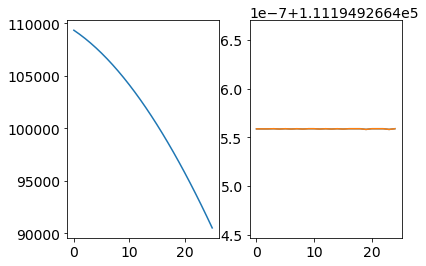

In [8]:
lt = np.zeros((26, 2))
lt[:, 0] = np.arange(10.5, 36, 1)
lt[:, 1] = np.arange(10.5, 36, 1)

ln = np.zeros((26, 2))
for i in np.arange(26):
    ln[i, 0] = 0
    ln[i, 1] = 1
l1 = gsw.distance(ln, lt, axis=1)
l2 = gsw.distance(ln, lt, axis=0)
plt.subplot(121)
plt.plot(l1)
plt.subplot(122)
plt.plot(l2)

In [4]:
def compute_speed(x_mean, lat0, lat1, y_mean, lon0, lon1, day):
    lat_bin = np.arange(10.5, 35.5, 1)

    index = np.abs(lat_bin - y_mean).argmin()
    speed_x = (lon1 - lon0) * l1[index] / (day * 86400)

    speed_y = (lat1 - lat0) * l2[0] / (day * 86400)
    return speed_x, speed_y

In [5]:
def find_nearest_id(x0, x1):
    index = np.abs(x0 - x1).argmin()
    return index

In [9]:
df = pd.read_pickle('../ssh_eddy_30.pkl')

eddyid = np.unique(df.id).tolist()
cols = ['x', 'y', 'L', 'u', 'v', 'y_bin']
df_ssh_u = pd.DataFrame(columns=cols)

bin_y0 = np.arange(10, 36, 2.5)
for i in np.arange(int(df.shape[0]/30)):
    id1 = i * 30
    id2 = (i+1) * 30
    dftmp = df.iloc[id1:id2]
    #dftmp = df.loc[df.id == id]
    x_mean = dftmp.x.mean()
    y_mean = dftmp.y.mean()
    L_mean = dftmp.L.mean()

    lon0 = dftmp.x.iloc[0]
    lon1 = dftmp.x.iloc[-1]

    lat0 = dftmp.y.iloc[0]
    lat1 = dftmp.y.iloc[-1]
    life = dftmp.life.iloc[0]
    
    utmp, vtmp = compute_speed(x_mean, lat0, lat1, y_mean, lon0, lon1, 30)

    y_bin = bin_y0[find_nearest_id(bin_y0, lat0)]
    data = {'x': x_mean,
            'y': y_mean,
            'L': L_mean,
            'y_bin': y_bin,
            'u': utmp[0],
            'v': vtmp[0]}

    df_ssh_u = df_ssh_u.append(data, ignore_index=True)

In [10]:
data_ssh_u = [df_ssh_u.u.loc[df_ssh_u.y_bin==bin_num].tolist() for bin_num in bin_y0]

In [11]:
df = pd.read_pickle('../ssh_eddy_90.pkl')

eddyid = np.unique(df.id).tolist()
cols = ['x', 'y', 'L', 'u', 'v', 'y_bin']
df_ssh_u_90 = pd.DataFrame(columns=cols)

bin_y0 = np.arange(10, 36, 2.5)
for i in np.arange(int(df.shape[0]/90)):
    id1 = i * 90
    id2 = (i+1) * 90
    dftmp = df.iloc[id1:id2]
    #dftmp = df.loc[df.id == id]
    x_mean = dftmp.x.mean()
    y_mean = dftmp.y.mean()
    L_mean = dftmp.L.mean()

    lon0 = dftmp.x.iloc[0]
    lon1 = dftmp.x.iloc[-1]

    lat0 = dftmp.y.iloc[0]
    lat1 = dftmp.y.iloc[-1]
    life = dftmp.life.iloc[0]
    
    utmp, vtmp = compute_speed(x_mean, lat0, lat1, y_mean, lon0, lon1, 90)

    y_bin = bin_y0[find_nearest_id(bin_y0, lat0)]
    data = {'x': x_mean,
            'y': y_mean,
            'L': L_mean,
            'y_bin': y_bin,
            'u': utmp[0],
            'v': vtmp[0]}

    df_ssh_u_90 = df_ssh_u_90.append(data, ignore_index=True)

In [12]:
df_rclv_uv = pd.read_pickle('/home/tls2913/scripts/RCLV/statistics_2d/rclv_30_0.1/df_rclv_uv.pkl')

In [13]:
data_rclv_u = [df_rclv_uv.u.loc[df_rclv_uv.y_bin==bin_num].tolist() for bin_num in bin_y0]

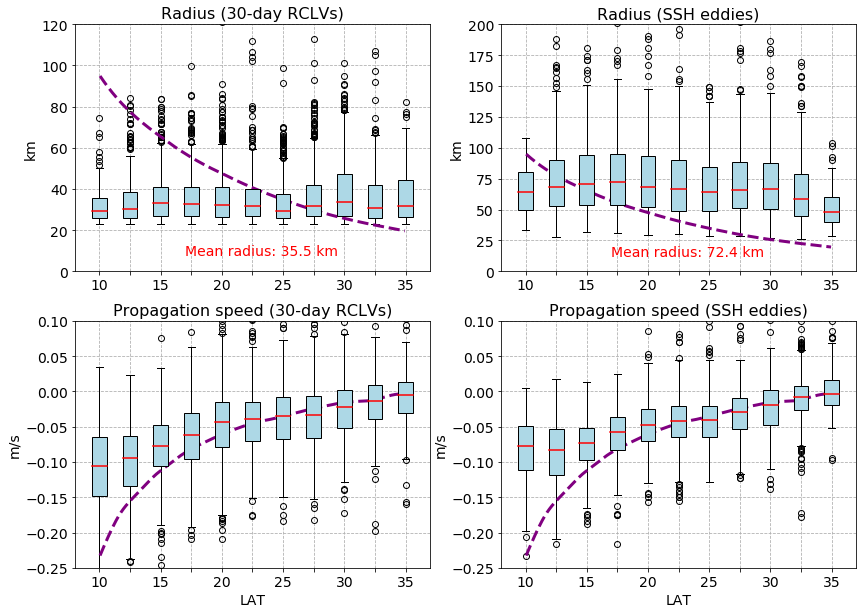

In [27]:
fig = plt.figure(figsize=(14, 10))

plt.subplot(221)
medianprops = dict(linestyle='-', linewidth=1.5, color='red')
capprops = dict(linewidth=1, color='k')
boxprops = dict(facecolor='lightblue', edgecolor='red')

plt.boxplot(data_rclv, positions=bin_y0, showfliers=True, widths=1.2, patch_artist=True,
            medianprops=medianprops, boxprops=boxprops, capprops=capprops)

plt.plot(lat[100:350], np.nanmean(rad[100:350], 1)/1000, color='purple', linestyle='--', linewidth=3)

plt.ylim(0, 120)
plt.xlim(8, 37)
plt.xticks(ticks=np.arange(10, 36, 2.5), labels=[
           '10', '', '15', '', '20', '', '25', '', '30', '', '35'])
plt.yticks(ticks=np.arange(0, 121, 20))
plt.grid(linestyle='--')
plt.ylabel('km')
plt.title('Radius (30-day RCLVs)')
plt.text(17, 8, 'Mean radius: 35.5 km', color='r')

plt.subplot(222)
medianprops = dict(linestyle='-', linewidth=1.5, color='red')
capprops = dict(linewidth=1, color='k')
boxprops = dict(facecolor='lightblue', edgecolor='red')

plt.boxplot(data_ssh, positions=bin_y0, showfliers=True, widths=1.2, patch_artist=True,
            medianprops=medianprops, boxprops=boxprops, capprops=capprops)

plt.plot(lat[100:350], np.nanmean(rad[100:350], 1)/1000, color='purple', linestyle='--', linewidth=3)

plt.ylim(0, 200)
plt.xlim(8, 37)
plt.xticks(ticks=np.arange(10, 36, 2.5), labels=[
           '10', '', '15', '', '20', '', '25', '', '30', '', '35'])
plt.yticks(ticks=np.arange(0, 205, 25))
plt.grid(linestyle='--')
plt.ylabel('km')
plt.title('Radius (SSH eddies)')
plt.text(17, 12, 'Mean radius: 72.4 km', color='r')

plt.subplot(223)

medianprops = dict(linestyle='-', linewidth=1.5, color='red')
capprops = dict(linewidth=1, color='k')
boxprops = dict(facecolor='lightblue', edgecolor='red')

plt.boxplot(data_rclv_u, positions=bin_y0, showfliers=True, widths=1.2, patch_artist=True,
            medianprops=medianprops, boxprops=boxprops, capprops=capprops)

plt.plot(lat[100:350], np.nanmean(uc[100:350], 1), color='purple', linestyle='--', linewidth=3)

plt.ylim(-0.25, 0.1)
plt.xlim(8, 37)
plt.xticks(ticks=np.arange(10, 36, 2.5), labels=[
           '10', '', '15', '', '20', '', '25', '', '30', '', '35'])
#plt.yticks(ticks=np.arange(0, 205, 25))
plt.grid(linestyle='--')
plt.xlabel('LAT')
plt.ylabel('m/s')
plt.title('Propagation speed (30-day RCLVs)')

plt.subplot(224)
medianprops = dict(linestyle='-', linewidth=1.5, color='red')
capprops = dict(linewidth=1, color='k')
boxprops = dict(facecolor='lightblue', edgecolor='red')

plt.boxplot(data_ssh_u, positions=bin_y0, showfliers=True, widths=1.2, patch_artist=True,
            medianprops=medianprops, boxprops=boxprops, capprops=capprops)

plt.plot(lat[100:350], np.nanmean(uc[100:350], 1), color='purple', linestyle='--', linewidth=3)

plt.ylim(-0.25, 0.1)
plt.xlim(8, 37)
plt.xticks(ticks=np.arange(10, 36, 2.5), labels=[
           '10', '', '15', '', '20', '', '25', '', '30', '', '35'])
#plt.yticks(ticks=np.arange(0, 205, 25))
plt.grid(linestyle='--')
plt.xlabel('LAT')
plt.ylabel('m/s')
plt.title('Propagation speed (SSH eddies)')

plt.savefig('Figure_05.png', dpi=300, bbox_inches='tight')

## Transport

/home/tls2913/.conda/envs/geo_scipy/lib/python3.6/site-packages/xmitgcm/utils.py:336: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/tls2913/.conda/envs/geo_scipy/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/home/tls2913/.conda/envs/geo_scipy/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in greater


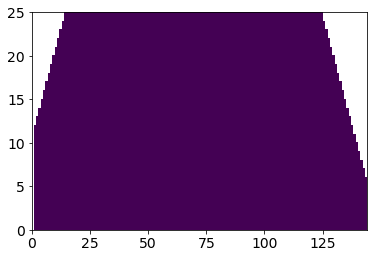

In [17]:
x_new = np.arange(144)
y_new = np.arange(10, 35, 1)
data_dir = '/swot/SUM01/tongya/cox/fine/run_quik_ex2/'
ds = open_mdsdataset(data_dir, prefix={'Depth'}).chunk()
dep = ds.Depth
dep = dep.interp(XC=x_new, YC=y_new)
dep = dep.where(dep > 0)
dep_mask = dep.load().data
dep_mask[np.where(dep_mask > 0)] = 1
plt.pcolormesh(dep_mask)

In [14]:
df_rclv_uv = pd.read_pickle('/home/tls2913/scripts/RCLV/statistics_2d/rclv_30_0.1/df_rclv_uv.pkl')
df_rclv_uv_90 = pd.read_pickle('/home/tls2913/scripts/RCLV/statistics_2d/rclv_30_0.1/df_rclv_uv_90.pkl')

ssh_tranx_30 = 2 * df_ssh_u.L * df_ssh_u.u * 1000
ssh_tranx_90 = 2 * df_ssh_u_90.L * df_ssh_u_90.u * 1000

rclv_tranx_30 = 2 * df_rclv_uv.L * df_rclv_uv.u * 1000
rclv_tranx_90 = 2 * df_rclv_uv_90.L * df_rclv_uv_90.u * 1000

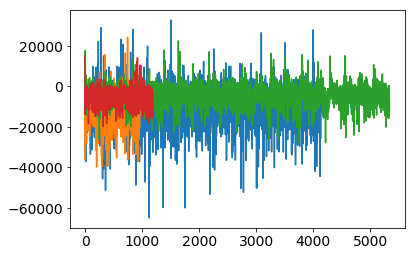

In [15]:
plt.plot(ssh_tranx_30)
plt.plot(ssh_tranx_90)

plt.plot(rclv_tranx_30)
plt.plot(rclv_tranx_90)

In [23]:
#------------------------------
# ssh 30 days
tranx1_30 = copy.deepcopy(dep_mask)

for i in np.arange(len(ssh_tranx_30)):
    tmpx = df_ssh_u.x.iloc[i]
    tmpy = df_ssh_u.y.iloc[i]

    idx = find_nearest_id(x_new, tmpx)
    idy = find_nearest_id(y_new, tmpy)

    tranx1_30[idy, idx] += ssh_tranx_30.iloc[i]
tranx1_30 = tranx1_30 / 20
#---------------------------------
# ssh 90 days
tranx1_90 = copy.deepcopy(dep_mask)

for i in np.arange(len(ssh_tranx_90)):
    tmpx = df_ssh_u_90.x.iloc[i]
    tmpy = df_ssh_u_90.y.iloc[i]

    idx = find_nearest_id(x_new, tmpx)
    idy = find_nearest_id(y_new, tmpy)

    tranx1_90[idy, idx] += ssh_tranx_90.iloc[i]
tranx1_90 = tranx1_90 / 20
#----------------------------
# rclv 30
tranx2_30 = copy.deepcopy(dep_mask)

#eddyid = np.unique(df.id).tolist()

for i in np.arange(len(rclv_tranx_30)):
    tmpx = df_rclv_uv.x.iloc[i]
    tmpy = df_rclv_uv.y.iloc[i]

    idx = find_nearest_id(x_new, tmpx)
    idy = find_nearest_id(y_new, tmpy)

    tranx2_30[idy, idx] += rclv_tranx_30.iloc[i]
tranx2_30 = tranx2_30 / 20
#----------------------------
# rclv 90
tranx2_90 = copy.deepcopy(dep_mask)

for i in np.arange(len(rclv_tranx_90)):
    tmpx = df_rclv_uv_90.x.iloc[i]
    tmpy = df_rclv_uv_90.y.iloc[i]

    idx = find_nearest_id(x_new, tmpx)
    idy = find_nearest_id(y_new, tmpy)

    tranx2_90[idy, idx] += rclv_tranx_90.iloc[i]
tranx2_90 = tranx2_90 / 20

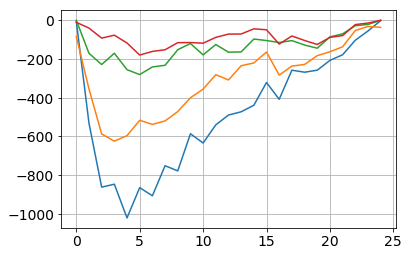

In [24]:
plt.plot(np.nanmean(tranx1_30,1))
plt.plot(np.nanmean(tranx2_30,1))
plt.plot(np.nanmean(tranx1_90,1))
plt.plot(np.nanmean(tranx2_90,1))
plt.grid()

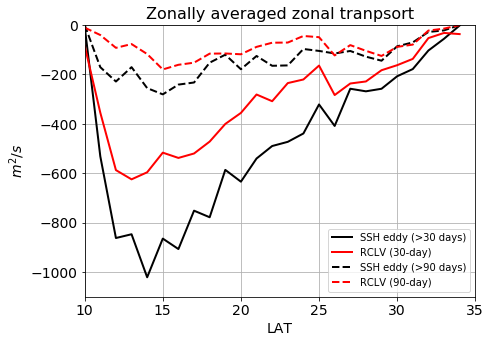

In [25]:
fig = plt.figure(figsize=(7, 5))
lat = np.arange(10, 35, 1)
plt.plot(lat, np.nanmean(tranx1_30,1), color='k', linestyle='-', linewidth=2, label='SSH eddy (>30 days)')
plt.plot(lat, np.nanmean(tranx2_30,1), color='r', linestyle='-', linewidth=2, label='RCLV (30-day)')
plt.plot(lat, np.nanmean(tranx1_90,1), color='k', linestyle='--', linewidth=2, label='SSH eddy (>90 days)')
plt.plot(lat, np.nanmean(tranx2_90,1), color='r', linestyle='--', linewidth=2, label='RCLV (90-day)')
plt.ylim(-1100, 0.1)
plt.xlim(10, 35)
plt.xlabel('LAT')
plt.ylabel('$m^2/s$')
plt.grid()
plt.legend()
plt.title('Zonally averaged zonal tranpsort')

plt.savefig('Figure_06.png', dpi=300, bbox_inches='tight')